# Importy

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import re
import time
import ast

from bs4 import BeautifulSoup
from gazpacho import Soup
from lxml import etree
from time import gmtime, strftime

from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings("ignore")

# Pobieranie danych

In [ ]:
names = []
numbers_review = []
categories = []
reviews = []


def gather_from_site(elements, start_id):
    names = []
    numbers_review = []
    categories = []
    reviews = []
    links = []  ###
    details = []
    user_reviews = []

    print(start_id)
    for i, element in enumerate(elements[:32]):
        # if
        # else:

        link = ""
        element_soupe = BeautifulSoup(str(element), "html.parser")
        dom = etree.HTML(str(element_soupe))
        name = None
        try:
            name = dom.xpath(
                "/html/body/div/div/div[2]/header/div/div[2]/div[1]/div/a"
            )[0].text
        except:
            try:
                name = element_soupe.select("h3 > a")[0].text
            except Exception as e:
                print(e, "0----", element_soupe, "SOMETHING WENT WRONG WITH NAME")
                return 0

        names.append(name)
        link = None
        try:
            link = f'https://www.tripadvisor.com{dom.xpath("/html/body/div/div/div[2]/header/div/div[2]/div[1]/div/a")[0].attrib["href"]}'
        except:
            try:
                link = f'https://www.tripadvisor.com{element_soupe.select("h3 > a")[0]["href"]}'
            except Exception as e:
                print(e, "0----", element_soupe, "SOMETHING WENT WRONG WITH LINK")
                return 0
            # TODO: move this to function
        try_again = False
        try:
            response = requests.get(
                link,
                headers={"User-Agent": "Safari/537.36"},
            )
            try_again = False
        except Exception as e:
            print("link", link, "<-------------", e)
            try_again = True
        while try_again:
            try:
                response = requests.get(
                    link,
                    headers={"User-Agent": "Safari/537.36"},
                )
                try_again = False
            except Exception as e:
                print("link", link, "<-------------", e)
                try_again = True
        soup_details = BeautifulSoup(response.text, "html.parser")
        detail = gather_from_link_details(soup_details)
        details.append(detail)
        user_review = gather_from_link_user_reviews(soup_details)
        user_reviews.append(user_review)

        links.append(link)

        number_review = ""
        try:
            number_review = dom.xpath(
                "/html/body/div/div/div[2]/header/div/div[2]/div[2]/div/div[1]/span[1]/span/span/a/span[2]"
            )[0].text.split()[0]

        except Exception as e:
            try:
                number_review = element_soupe.select(" span > span > a > span")[1].text

            except Exception as e:
                print(
                    e, "0----", element_soupe, "SOMETHING WENT WRONG WITH number_review"
                )
                # return 0

        numbers_review.append(number_review)
        category = []
        try:
            category = dom.xpath(
                "/html/body/div/div/div[2]/header/div/div[2]/div[2]/div/div[2]/span[1]/span"
            )[0].text.split(",")

        except Exception as e:
            try:
                category = element_soupe.select(
                    "div > div> div > div> div > div:nth-child(2) > span:nth-child(1) > span"
                )[0].text.split(",")
            except Exception as e:
                print(e, "0----", element_soupe, "SOMETHING WENT WRONG WITH category")
                # return 0
        categories.append(category)

        review = None
        try:
            review = (
                dom.xpath(
                    "/html/body/div/div/div[2]/header/div/div[2]/div[2]/div/div[1]/span[1]/span/span/a/span[1]/svg"
                )[0]
                .attrib["aria-label"]
                .split()[0]
            )

        except Exception as e:
            try:
                review = element_soupe.select(
                    "div > div> div> div> div > div:nth-child(1) > span > span > span > a > span> svg"
                )[0]["aria-label"].split()[0]
            except Exception as e:
                print(
                    e, "0----", element_soupe, "SOMETHING WENT WRONG WITH review number"
                )
                # return 0

        reviews.append(review)
        data = tuple(
            str(e)
            for e in (
                start_id,
                name,
                number_review,
                category,
                review,
                link,
                detail,
                user_review,
            )
        )
        con = sqlite3.connect("tripAdvisor.db")
        cur = con.cursor()
        cur.execute("INSERT INTO Restaurant VALUES(?, ?, ?, ?, ?, ?,?,?)", data)
        con.commit()
        cur.close()
        con.close()
        print(f"Done {i} from 32")
        start_id += 1

    return (
        names,
        numbers_review,
        categories,
        reviews,
        links,
        details,
        user_reviews,
    )


def gather_from_link_user_reviews(soupe):
    dom = etree.HTML(str(soupe))
    try:
        return (
            list(
                dom.xpath(
                    "/html/body/div[3]/div[2]/div[2]/div[6]/div/div[1]/div[3]/div/div[5]/div"
                )[0].itertext()
            ),
        )
    except:
        return None


def gather_from_link_details(soupe):
    dom = etree.HTML(str(soupe))
    try:
        return (
            list(
                dom.xpath(
                    "/html/body/div[3]/div[2]/div[2]/div[2]/div/div[1]/div/div[2]/div/div"
                )[0].itertext()
            ),
        )
    except:
        return None


def write_to_csv(
    names,
    categories,
    reviews,
    numbers_review,
    links,
    url,
    soup,
    user_reviews,
    details,
):
    curr_time = strftime("%Y-%m-%d_%H-%M-%S", localtime())

    print("last url: ", url)
    with open(f"results/last_html{curr_time}.html", "w", encoding="utf-8") as f:
        f.write(str(soup))
    with open(f"results/backup_values{curr_time}.txt", "w", encoding="utf-8") as f:
        f.write(str(names))
        f.write("\n-------\n")
        f.write(str(categories))
        f.write("\n-------\n")
        f.write(str(reviews))
        f.write("\n-------\n")
        f.write(str(numbers_review))
        f.write("\n-------\n")
        f.write(str(links))
        f.write("\n-------\n")
        f.write(str(user_reviews))
        f.write("\n-------\n")
        f.write(str(details))
        f.write("\n-------\n")
    print(
        len(names),
        len(categories),
        len(reviews),
        len(numbers_review),
        len(links),
        len(user_reviews),
        len(details),
    )
    list_of_items = pd.DataFrame(
        {
            "Name": names,
            "Categories": categories,
            "Review": reviews,
            "Number of Review": numbers_review,
            "Links": links,
            "User reviews": user_reviews,
            "Details": details,
        }
    )
    list_of_items.to_csv(f"results/tripAdvisor{curr_time}.csv", index=False)


def scrap(loop=70):
    page = 0
    url = "https://www.tripadvisor.com/Restaurants-g274856-Warsaw_Mazovia_Province_Central_Poland.html"
    start_id = 0
    processes = []
    try:
        while page < loop:
            time.sleep(0.1)
            response = requests.get(url, headers={"User-Agent": "Safari/537.36"})
            soup = BeautifulSoup(response.text, "html.parser")
            soup_gazpacho = Soup(str(soup))
            elements = soup_gazpacho.find(
                "div", attrs={"data-test": "_list_item"}, partial=True
            )
            sleep = 0.1
            while elements is None or len(elements) == 0:
                print("I did not get info, trying again sleep value", sleep, url)
                time.sleep(sleep)
                response = requests.get(url, headers={"User-Agent": "Safari/537.36"})
                soup = BeautifulSoup(response.text, "html.parser")
                soup_gazpacho = Soup(str(soup))
                elements = soup_gazpacho.find(
                    "div", attrs={"data-test": "_list_item"}, partial=True
                )
                sleep += 0.05
            processes.append(
                Process(target=gather_from_site, args=(elements, start_id))
            )
            start_id += 32
            try:
                next_url = soup.find("a", attrs={"aria-label": "Next page"})["href"]
            except:
                try:
                    next_url = soup.find("a", {"class": "next"})["href"]
                except:
                    print("chyba się udało sprawdź plik wynikowy")
                    return 1

            url = f" https://www.tripadvisor.com/{next_url}"
            page += 1
            print(
                "Gathering info from page number ",
                page,
                "with url ",
                url,
            )
        for process in processes:
            process.start()
        # wait on all processes
        for process in processes:
            process.join()
        print("Done scanning, start scrapping!!!")
    except Exception as e:
        print("Coś poszło nie tak :-(")
        print("bład", e)
    print("Skończone scrappowanie")


def create_new_db(con):
    cur = con.cursor()
    cur.execute("DROP TABLE IF EXISTS Restaurant;")

    cur.execute(
        "CREATE TABLE Restaurant(id,names,numbers_review,categories,reviews,links,details,user_reviews)"
    )
    con.execute("PRAGMA busy_timeout = 30000")
    cur.close()
    con.close()


def convert_sqlite_to_csv():
    con = sqlite3.connect("tripAdvisor.db")
    curr_time = strftime("%Y-%m-%d_%H-%M-%S", localtime())
    db_df = pd.read_sql_query("SELECT * FROM Restaurant", con)
    db_df.to_csv("results/trip.csv", index=False)
    print("plik zapisano:)")


def main(con):
    create_new_db(con)

    scrap()

    convert_sqlite_to_csv()
    con.close()

In [ ]:
main(sqlite3.connect("tripAdvisor.db"))

# Wczytanie i przetwarzanie danych

In [187]:
df_orginal = pd.read_csv("/Users/kasia/Desktop/programowanie/big-data/results/trip.csv")
df_orginal

,id,names,numbers_review,categories,reviews,links,details,user_reviews
0,32,FALLA Warszawa Mokotow,6 reviews,"['Healthy', ' Bar']",5.0,https://www.tripadvisor.com/Restaurant_Review-...,"(['Special offer', 'APEROL DAY AND NIGHT ', 'E...","(['\n', '\n', ' ', '390krisztih', '9 reviews',..."
1,96,Kuk Restaurant,9 reviews,['Polish'],5.0,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$6 - $63', 'CUISI...","(['\n', '\n', ' ', 'Magdalena S', '1 review', ..."
2,0,Executive Lounge Browary,11 reviews,"['European', ' Asian']",5.0,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$5 - $35', 'CUISI...","(['\n', '\n', ' ', 'Klinth P', '1 review', 'Re..."
3,64,DOCK19 By Mateusz Gessler,12 reviews,"['Polish', ' European']",4.5,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$10 - $150', 'CUI...","(['\n', '\n', ""Restaurant's Favorite"", ' ', 'b..."
4,256,Executive Lounge Browary,11,"['Bar', ' European']",5.0,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$5 - $35', 'CUISI...","(['\n', '\n', ' ', 'Klinth P', '1 review', 'Re..."
...,...,...,...,...,...,...,...,...
2555,223,206. La Lucy,68 reviews,"['Cafe', ' European']",4.5,https://www.tripadvisor.com/Restaurant_Review-...,"(['Food and ambience', 'Cafe, European, Health...","(['\n', '\n', ' ', 'kiwipand', '1 review', 'Re..."
2556,95,86. Wabu Sushi & Japanese Tapas,486 reviews,"['Japanese', ' Sushi']",4.5,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$12 - $63', 'CUIS...","(['\n', '\n', ' ', 'Simone N', '14 reviews', '..."
2557,127,118. La Dolce Vita,811 reviews,"['Pizza', ' Italian']",4.0,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$6 - $28', 'CUISI...","(['\n', '\n', ' ', 'Pavol B', '1 review', 'Rev..."
2558,159,146. Rasoi Indian Restaurant,128,"['Indian', ' Grill']",4.5,https://www.tripadvisor.com/Restaurant_Review-...,"(['Details', 'PRICE RANGE', '$5 - $13', 'CUISI...","(['\n', '\n', ' ', 'Ronen99', '388 reviews', '..."


In [253]:
def clean_name(text):
    new_text = re.sub(r"[!@#$%^&*()\[\]{};:,./<>?\|`~\-=_+]", "", text)
    new_text = re.sub(r"\d+", "", new_text)
    new_text = re.sub(r"\s+", " ", new_text)
    new_text = re.sub(r"^\s+|\s+$", "", new_text)
    #new_text = new_text.strip()
    return new_text

def clean_categories(categories):
    categories = ast.literal_eval(categories)  
    categories = [category.lstrip() if category.startswith(' ') else category for category in categories]
    categories = sorted(categories)  
    categories = ', '.join(categories)  
    return categories

def check_empty_category(df):
    df['categories'] = df['categories'].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)
    return df

def clean_reviews(text):
    cleaned_text = re.sub(r"'\\n\'", "", text)
    cleaned_text = re.sub(r"[^a-zA-Z,\s]", "", cleaned_text)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    cleaned_text = re.sub(r"\s,+", "", cleaned_text)
    cleaned_text = re.sub("This review is the subjective opinion of a Tripadvisor member and not of Tripadvisor LLC Tripadvisor performs checks on reviews as part of our industryleading trust safety standards Read our transparency report, to learn more,", "", cleaned_text)
    return cleaned_text[2:]

def process_details(details):
    details = details.replace("(", "")
    details = details.replace(",)", "")
    details = details.replace(r"\xa0", " ")

    details = ast.literal_eval(details)
    details = [i.lstrip() if i.startswith(' ') else i for i in details]

    elements = ['PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals', 'FEATURES', 'Special offer']
    result = {}

    for i in range(len(details) - 1):
        if details[i] in elements:
            result[details[i]] = details[i + 1]
        else:
            for element in elements:
                if element not in result:
                    result[element] = np.nan
    return result

def calculate_rating(row):
    try:
        reviews_normalized = float(row['reviews_normalized'])
        numbers_review = float(row['numbers_review'])
        rating = reviews_normalized * np.log(numbers_review)
        return rating
    except (ValueError, TypeError):
        return np.nan

def merge_values(row):
    columns_to_merge = ['categories', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals']
    values = [row[column] for column in columns_to_merge if not pd.isna(row[column])]
    return ', '.join(values) if values else 'NaN'

def remove_duplicates_and_commas(text):
    words = text.split(", ")
    unique_words = list(dict.fromkeys(words))
    cleaned_text = " ".join(unique_words)
    return cleaned_text

df = df_orginal.copy()

df.dropna(how='all', inplace=True)

df['names'] = df['names'].apply(clean_name)
df['names'] = df['names'].drop_duplicates()
df['names'].replace(['None', 'N/A'], np.nan, inplace=True)
df.dropna(subset=['names'], inplace=True)

df['categories'] = df['categories'].apply(clean_categories)
df['categories'].replace(['\n\n\n\n\n\n\n\n\n                  Menu\n                  \n\n\n\n', '$$ - $$$', '$'], np.nan, inplace=True)
df = check_empty_category(df)

df['reviews'] = pd.to_numeric(df['reviews'], errors='coerce')
min_review = df['reviews'].min()
max_review = df['reviews'].max()
df['reviews_normalized'] = round((df['reviews'] - min_review) / (max_review - min_review), 3)
df = df[['names', 'categories', 'reviews', 'reviews_normalized', 'numbers_review',
       'user_reviews', 'details', 'links']]

df['numbers_review'] = df['numbers_review'].str.replace(' reviews', '')
df['numbers_review'] = df['numbers_review'].str.replace(',', '')
df['numbers_review'] = pd.to_numeric(df['numbers_review'], errors='coerce').astype('Int64')

df['rating'] = df.apply(calculate_rating, axis=1)
min_rating = df['rating'].min()
max_rating = df['rating'].max()
df['rating'] = round((df['rating'] - min_rating) / (max_rating - min_rating), 3)

df['user_reviews'] = df['user_reviews'].apply(clean_reviews)

df['details'] = df['details'].apply(process_details)
for column in ['PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals', 'FEATURES', 'Special offer']:
    df[column] = df['details'].apply(lambda x: x.get(column))
df = df.drop('details', axis=1)

df['all_features'] = df.apply(merge_values, axis=1)
df['all_features'] = df['all_features'].apply(lambda x: remove_duplicates_and_commas(x))
df['all_features'] = df['all_features'].replace('NaN', np.nan, regex=True)
df.dropna(subset=['all_features'], inplace=True)

df = df.reset_index(drop=True)
df 

,names,categories,reviews,reviews_normalized,numbers_review,user_reviews,links,rating,PRICE RANGE,CUISINES,Special Diets,Meals,FEATURES,Special offer,all_features
0,FALLA Warszawa Mokotow,"Bar, Healthy",5.0,1.00,6,"krisztih, reviews, Reviewed days ago via mobil...",https://www.tripadvisor.com/Restaurant_Review-...,0.224,NaN,NaN,NaN,NaN,NaN,APEROL DAY AND NIGHT,Bar Healthy
1,Kuk Restaurant,Polish,5.0,1.00,9,"Magdalena S, review, Reviewed days ago Chill,e...",https://www.tripadvisor.com/Restaurant_Review-...,0.275,$6 - $63,Polish,NaN,"Lunch, Dinner, Drinks",NaN,NaN,Polish $6 - $63 Lunch Dinner Drinks
2,Executive Lounge Browary,"Asian, European",5.0,1.00,11,"Klinth P, review, Reviewed March best shisha a...",https://www.tripadvisor.com/Restaurant_Review-...,0.300,$5 - $35,"European, Asian, Fusion, Bar, Pub, Healthy",NaN,"Dinner, Late Night, Drinks",NaN,NaN,Asian European $5 - $35 Fusion Bar Pub Healthy...
3,DOCK By Mateusz Gessler,"European, Polish",4.5,0.75,12,"Restaurants Favorite, bildform, reviews, Revie...",https://www.tripadvisor.com/Restaurant_Review-...,0.233,$10 - $150,"Polish, European, Asian",NaN,"Lunch, Dinner, Late Night, Drinks",NaN,NaN,European Polish $10 - $150 Asian Lunch Dinner ...
4,Quattro Formaggi,"Italian, Northern-Italian",5.0,1.00,14,"Stelio Z, reviews, Reviewed weeks ago Amazing ...",https://www.tripadvisor.com/Restaurant_Review-...,0.330,NaN,"Italian, Northern-Italian, Central-Italian, So...",NaN,"Lunch, Dinner",NaN,NaN,Italian Northern-Italian Central-Italian South...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Food Hall Elektrownia PowiSle,"Pizza, Sushi",4.5,0.75,59,"panul, reviews, Reviewed week ago via mobile S...",https://www.tripadvisor.com/Restaurant_Review-...,0.382,$5 - $18,"Pizza, Sushi, Vietnamese, Street Food, European",NaN,"Lunch, Dinner, Brunch, Late Night, Drinks",NaN,NaN,Pizza Sushi $5 - $18 Vietnamese Street Food Eu...
1741,La Lucy,"Cafe, European",4.5,0.75,68,"kiwipand, review, Reviewed March via mobile Te...",https://www.tripadvisor.com/Restaurant_Review-...,0.396,NaN,NaN,NaN,NaN,NaN,NaN,Cafe European
1742,Wabu Sushi Japanese Tapas,"Japanese, Sushi",4.5,0.75,486,"Simone N, reviews, Reviewed week ago via mobil...",https://www.tripadvisor.com/Restaurant_Review-...,0.580,$12 - $63,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...",NaN,NaN,NaN,Japanese Sushi $12 - $63 Asian Vegetarian Frie...
1743,La Dolce Vita,"Italian, Pizza",4.0,0.50,811,"Pavol B, review, Reviewed weeks ago via mobile...",https://www.tripadvisor.com/Restaurant_Review-...,0.419,$6 - $28,"Pizza, Italian, Mediterranean, European","Vegetarian Friendly, Vegan Options, Gluten Fre...",NaN,NaN,NaN,Italian Pizza $6 - $28 Mediterranean European ...


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   names               1745 non-null   object 
 1   categories          1582 non-null   object 
 2   reviews             1744 non-null   float64
 3   reviews_normalized  1744 non-null   float64
 4   numbers_review      1634 non-null   Int64  
 5   user_reviews        1745 non-null   object 
 6   links               1745 non-null   object 
 7   rating              1634 non-null   float64
 8   PRICE RANGE         774 non-null    object 
 9   CUISINES            1539 non-null   object 
 10  Special Diets       429 non-null    object 
 11  Meals               1078 non-null   object 
 12  FEATURES            298 non-null    object 
 13  Special offer       6 non-null      object 
 14  all_features        1745 non-null   object 
dtypes: Int64(1), float64(3), object(11)
memory usage: 206.3

In [227]:
df.to_csv("after_prep.csv", index=False, sep=';')

# Wizualizacja danych

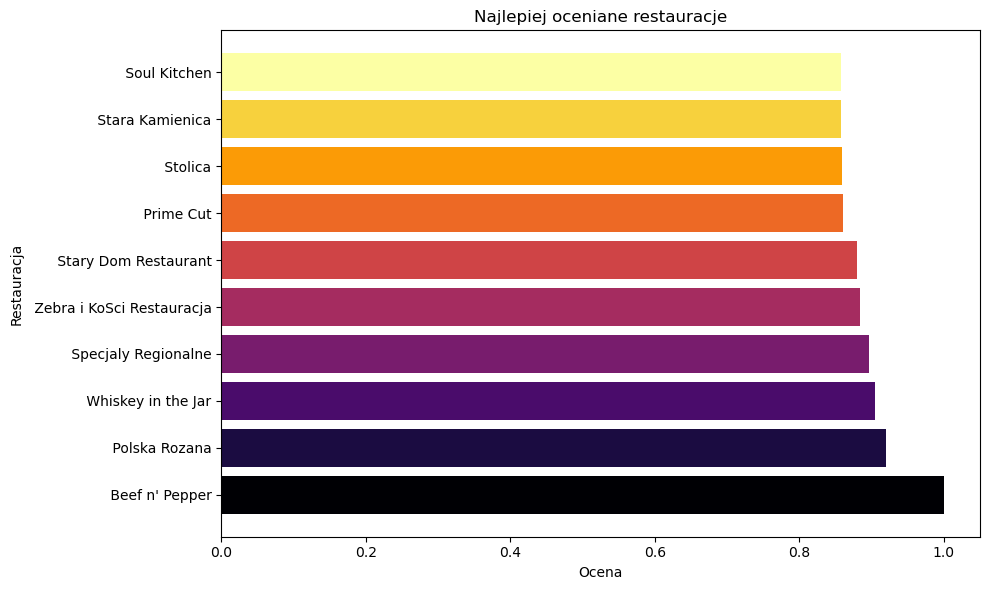

In [23]:
df_sorted = df.sort_values('rating', ascending=False)
top_10_restaurants = df_sorted.head(10)

colors = []
cmap = plt.get_cmap("inferno")
data = [i for i in range(1,11)]
denominator = max(data) - min(data)
scaled_data = [(datum-min(data))/denominator for datum in data]
for i in scaled_data:
    colors.append(cmap(i))

plt.figure(figsize=(10,6))
plt.barh(top_10_restaurants['names'], top_10_restaurants['rating'], color=colors)
plt.xlabel('Ocena')
plt.ylabel('Restauracja')
plt.title('Najlepiej oceniane restauracje')
plt.tight_layout()
plt.show()

# Algorytm poleceń

In [254]:
df.set_index('names', inplace=True)
indices = pd.Series(df.index)

tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['all_features'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [258]:
def recommend_by_name(name, cosine_similarities=cosine_similarities):
    idx = indices[indices == name].index[0]
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    top30_indexes = list(score_series.iloc[1:31].index)

    recommend_restaurant = list(df.index[top30_indexes])

    df_new = df.loc[recommend_restaurant, ['categories', 'reviews', 'numbers_review', 'links', 'rating', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals']].copy()
    df_new['Similarity'] = score_series.iloc[1:31].values

    return df_new.head(10)
recommend_by_name('OTOSUSHI')

,categories,reviews,numbers_review,links,rating,PRICE RANGE,CUISINES,Special Diets,Meals,Similarity
names,,,,,,,,,,
Besuto Sushi Bar,"Japanese, Sushi",4.0,199,https://www.tripadvisor.com/Restaurant_Review-...,0.331,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Late Night",0.978880
Sushi Zushi,"Japanese, Sushi",4.5,431,https://www.tripadvisor.com/Restaurant_Review-...,0.569,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Late Night",0.978880
Soto Sushi Warynskiego,"Japanese, Sushi",4.5,536,https://www.tripadvisor.com/Restaurant_Review-...,0.589,$3 - $8,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...",NaN,0.883363
Kago Sushi,"Japanese, Sushi",4.0,78,https://www.tripadvisor.com/Restaurant_Review-...,0.272,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options","Lunch, Dinner, Late Night, Drinks",0.870467
Sakana Sushi Bar,"Japanese, Sushi",4.5,157,https://www.tripadvisor.com/Restaurant_Review-...,0.474,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Gluten Free Options","Lunch, Dinner, Late Night",0.845607
Kiku,Asian,4.0,176,https://www.tripadvisor.com/Restaurant_Review-...,0.323,NaN,Asian,"Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner",0.805070
Pracownia Sushi Wola,"Japanese, Sushi",4.0,169,https://www.tripadvisor.com/Restaurant_Review-...,0.321,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Vegan Options","Lunch, Dinner",0.783700
Tomo Sushi,"Japanese, Sushi",4.5,134,https://www.tripadvisor.com/Restaurant_Review-...,0.459,NaN,"Japanese, Sushi, Asian","Vegetarian Friendly, Gluten Free Options","Lunch, Dinner",0.783250
Pelna Para,Asian,4.5,222,https://www.tripadvisor.com/Restaurant_Review-...,0.506,NaN,Asian,"Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Brunch",0.772583


In [246]:
selected_columns = ['categories', 'CUISINES', 'Special Diets', 'Meals']

unique_lists = {}

combined_values = set()
for row in df['categories']:
    if isinstance(row, str):
        combined_values.update(row.split(', '))
for row in df['CUISINES']:
    if isinstance(row, str):
        combined_values.update(row.split(', '))

unique_lists['Category'] = list(combined_values)

for column in selected_columns:
    if column != 'categories' and column != 'CUISINES':
        unique_values = set()
        for row in df[column]:
            if isinstance(row, str):
                unique_values.update(row.split(', '))
        unique_lists[column] = list(unique_values)

for column, unique_values in unique_lists.items():
    print(f"{column}: {unique_values}")

Category: ['British', 'African', 'Latin', 'Romana', 'Peruvian', 'Central Asian', 'Mediterranean', 'Lebanese', 'Bar', 'Argentinean', 'Belgian', 'Street Food', 'Russian', 'Bangladeshi', 'Japanese', 'Dining bars', 'Caucasian', 'French', 'Greek', 'Cuban', 'Arabic', 'Egyptian', 'Pizza', 'Nepali', 'Caribbean', 'Italian', 'Israeli', 'Tibetan', 'Scandinavian', 'European', 'Taiwanese', 'Portuguese', 'Deli', 'Seafood', 'Persian', 'New Zealand', 'Pub', 'Polish', 'Tunisian', 'Japanese Fusion', 'Australian', 'Croatian', 'Central European', 'Pakistani', 'Assyrian', 'Fast Food', 'Moroccan', 'Irish', 'Fusion', '$$$$', 'Hawaiian', 'Neapolitan', 'Healthy', 'Uzbek', 'American', 'Gastropub', 'Balti', 'International', 'Korean', 'Middle Eastern', 'Chilean', 'Colombian', 'Soups', 'Cafe', 'Diner', 'Vietnamese', 'Steakhouse', 'Asian', 'Northern-Italian', 'Indian', 'Lazio', 'Contemporary', 'Hungarian', 'Menu', 'Barbecue', 'Central-Italian', 'Turkish', 'Beer restaurants', 'Chinese', 'Czech', 'Central American', 

In [262]:
cechy = 'Japanese Asian Vegan Options Dinner'

def recommend_by_features(selected_features, cosine_similarities=cosine_similarities):
    features_tfidf = tfidf.transform([selected_features])
    similarity_scores = cosine_similarity(features_tfidf, tfidf_matrix)

    sorted_indices = similarity_scores.argsort()[0][::-1][1:31]
    recommend_restaurant = list(df.index[sorted_indices])

    df_new = df.loc[recommend_restaurant, ['categories', 'reviews', 'numbers_review', 'links', 'rating', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals']].copy()
    df_new['Similarity'] = similarity_scores[0][sorted_indices]

    return df_new.head(10)

df_recom = recommend_by_features(cechy)
df_recom

,categories,reviews,numbers_review,links,rating,PRICE RANGE,CUISINES,Special Diets,Meals,Similarity
names,,,,,,,,,,
Silk and Spicy,"Japanese, Sushi",4.0,136,https://www.tripadvisor.com/Restaurant_Review-...,0.307,NaN,"Japanese, Sushi, Asian, Thai","Vegetarian Friendly, Vegan Options","Dinner, Lunch",0.404860
Parivar,Indian,4.5,61,https://www.tripadvisor.com/Restaurant_Review-...,0.385,NaN,Indian,"Vegetarian Friendly, Vegan Options","Dinner, Lunch",0.391060
Tobiko Sushi,"Japanese, Sushi",4.5,48,https://www.tripadvisor.com/Restaurant_Review-...,0.363,NaN,"Japanese, Sushi, Asian, Seafood","Vegetarian Friendly, Vegan Options","Dinner, Lunch",0.382784
Swagat,"Asian, Indian",4.5,65,https://www.tripadvisor.com/Restaurant_Review-...,0.391,NaN,"Indian, Asian","Vegetarian Friendly, Vegan Options","Dinner, Brunch, Lunch",0.376386
VEGAN RAMEN SHOP,"Fast Food, Japanese",4.5,26,https://www.tripadvisor.com/Restaurant_Review-...,0.305,NaN,"Japanese, Fast Food, Asian",NaN,NaN,0.375215
Pho Lovers,"Chinese, Japanese",4.5,29,https://www.tripadvisor.com/Restaurant_Review-...,0.316,NaN,"Chinese, Japanese, Asian, Thai, Vietnamese",NaN,"Lunch, Dinner",0.300009
Maghreb,"African, Moroccan",4.0,75,https://www.tripadvisor.com/Restaurant_Review-...,0.270,NaN,"African, Moroccan","Vegetarian Friendly, Vegan Options","Dinner, Lunch",0.286212
Bistro Eden,"European, Polish",4.0,17,https://www.tripadvisor.com/Restaurant_Review-...,0.177,NaN,"Polish, European, Japanese, Asian, Korean",NaN,"Lunch, Dinner, Brunch, Drinks",0.285887
Yemyemy Hand Pulled Noodles,"Chinese, Japanese",5.0,<NA>,https://www.tripadvisor.com/Restaurant_Review-...,NaN,NaN,"Chinese, Japanese, Asian, Street Food",NaN,"Lunch, Dinner",0.284796


# Interfejs uzytkownika

In [286]:
import streamlit as st
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings("ignore")

st.set_page_config(
    page_title="System rekomendacji restauracji",
    page_icon="👋",
)

st.title('System rekomendacji restauracji')

df = pd.read_csv('after_prep.csv', sep=';')
restaurants = df.names.to_list()

selected_columns = ['categories', 'CUISINES', 'Special Diets', 'Meals']

unique_lists = {}

combined_values = set()
for row in df['categories']:
    if isinstance(row, str):
        combined_values.update(row.split(', '))
for row in df['CUISINES']:
    if isinstance(row, str):
        combined_values.update(row.split(', '))

unique_lists['Category'] = list(combined_values)

for column in selected_columns:
    if column != 'categories' and column != 'CUISINES':
        unique_values = set()
        for row in df[column]:
            if isinstance(row, str):
                unique_values.update(row.split(', '))
        unique_lists[column] = list(unique_values)

df.set_index('names', inplace=True)
indices = pd.Series(df.index)

tfidf = text.TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['all_features'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

def recommend_by_name(name, cosine_similarities=cosine_similarities):
    idx = indices[indices == name].index[0]
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    top30_indexes = list(score_series.iloc[1:31].index)

    recommend_restaurant = list(df.index[top30_indexes])

    df_new = df.loc[recommend_restaurant, ['categories', 'reviews', 'numbers_review', 'links', 'rating', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals']].copy()
    df_new['Similarity'] = score_series.iloc[1:31].values

    return df_new.head(10)

def recommend_by_features(selected_features, cosine_similarities=cosine_similarities):
    features_tfidf = tfidf.transform([selected_features])
    similarity_scores = cosine_similarity(features_tfidf, tfidf_matrix)

    sorted_indices = similarity_scores.argsort()[0][::-1][1:31]
    recommend_restaurant = list(df.index[sorted_indices])

    df_new = df.loc[recommend_restaurant, ['categories', 'reviews', 'numbers_review', 'links', 'rating', 'PRICE RANGE', 'CUISINES', 'Special Diets', 'Meals']].copy()
    df_new['Similarity'] = similarity_scores[0][sorted_indices]

    return df_new.head(10)

col1, col2 = st.columns(2)

with col1:
    st.header('Wyszukiwanie po podobnych restauracjach')
    option = st.selectbox(
        'Wybierz restaurację, do której podobną chcesz znaleźć: ',
        (restaurants))
    df_recom_name = recommend_by_name(option)
    st.write('Wybrałeś: ', option)
    st.write('Rekomendacje: ', )
    st.dataframe(df_recom_name)

with col2:
    st.header('Wyszukiwanie po wytycznych')
    category = st.selectbox('Kategoria:', unique_lists['Category'])
    diets = st.selectbox('Dieta:', unique_lists['Special Diets'])
    meals = st.selectbox('Posiłki:', unique_lists['Meals'])
    options = category + ' ' + diets + ' ' + meals
    df_recom_feat = recommend_by_features(options)
    st.write('Wybrałeś: ', options)
    st.write('Rekomendacje: ', )
    st.dataframe(df_recom_feat)

In [287]:
import nbformat

def save_cell_code_to_py_file(notebook_path, cell_index, file_path):
    with open(notebook_path, "r", encoding="utf-8") as file:
        notebook_content = nbformat.read(file, as_version=4)
    
    code = notebook_content.cells[cell_index].source
    
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(code)

notebook_path = "/Users/kasia/Desktop/programowanie/big-data/projekt.ipynb"  
cell_index = 18
file_path = "/Users/kasia/Desktop/programowanie/big-data/interfejs.py"  

save_cell_code_to_py_file(notebook_path, cell_index, file_path)

In [288]:
!streamlit run interfejs.py

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.213:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
  Stopping...
